In [65]:
import h5py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

from data_analysis_codes.tools import TAradius
from data_analysis_codes.tools import LinData
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import GetVars_Plot2d as gvar

In [2]:
sim32 = RRead.read_parameters('pflrw_d3e2_L1821_t1_N32_LCDM')
sim64 = RRead.read_parameters('pflrw_d3e2_L1821_t1_N64_LCDM')
sim128 = RRead.read_parameters('pflrw_d3e2_L1821_t1_N128_LCDM')

Lin32 = LinData.LinData_Class(sim32)
Lin64 = LinData.LinData_Class(sim64)
Lin128 = LinData.LinData_Class(sim128)

f32 = pd.read_table(sim32['datapath'] + 'mass_radius_evo.csv', delimiter=',')
f64 = pd.read_table(sim64['datapath'] + 'mass_radius_evo.csv', delimiter=',')
f128 = pd.read_table(sim128['datapath'] + 'mass_radius_evo.csv', delimiter=',')

 read time file
 read time file
 read time file


In [3]:
nf32 = f32 #pd.read_table(sim32['datapath'] + 'new_mass_radius_evo.csv', delimiter=',')
nf64 = f64 #pd.read_table(sim64['datapath'] + 'new_mass_radius_evo.csv', delimiter=',')
nf128 = f128 #pd.read_table(sim128['datapath'] + 'new_mass_radius_evo.csv', delimiter=',')

In [4]:
def dichotomomy(y_wanted, function, lower_bound, upper_bound, tolerance):
    x_low = lower_bound
    x_upp = upper_bound
    x_mid = (x_low + x_upp) / 2
    y_low = function(x_low)
    y_upp = function(x_upp)
    y_mid = function(x_mid)
    while abs(y_wanted / y_mid - 1) > tolerance:
        if y_wanted > y_mid:
            y_low = y_mid
            x_low = x_mid
            x_mid = (x_low + x_upp) / 2
            y_mid = function(x_mid)
        else:
            y_upp = y_mid
            x_upp = x_mid
            x_mid = (x_low + x_upp) / 2
            y_mid = function(x_mid)
    return x_mid

In [5]:
def getRt(Lin, sim, f, i):
    RIN = np.mean([f['r_vertice_prop_'+str(i)][0], f['r_edge_prop_'+str(i)][0], f['r_face_prop_'+str(i)][0]])
    deltaIN = f['delta_dav_'+str(i)][0]
    
    rho = Lin.evo.rho(Lin.t_initial)*(1+deltaIN)
    Volume = (4*np.pi/3)*(RIN**3)
    M = rho*Volume
    
    deltaTA = 1.06
    anTA = deltaTA/deltaIN
    
    tTA = Lin.t_initial*(anTA)**(3/2)
    RTA = (8*M*(tTA**2)/np.pi**2)**(1/3)
    etaIN = np.arccos(1-2*RIN/RTA)
    eta = np.linspace(etaIN, 2*np.pi, len(f['r_vertice_prop_'+str(i)]))
    R = RTA*np.sin(eta/2)**2
    
    t = np.sqrt((RTA**3)/(2*M))*(eta-np.sin(eta))/2
    an = Lin.an_initial(t)
    
    return an, R, M

def getRtan(Lin, sim, f, t, i):
    RIN = np.mean([f['r_vertice_prop_'+str(i)][0], f['r_edge_prop_'+str(i)][0], f['r_face_prop_'+str(i)][0]])
    deltaIN = f['delta_dav_'+str(i)][0]
    
    rho = Lin.evo.rho(Lin.t_initial)*(1+deltaIN)
    Volume = (4*np.pi/3)*(RIN**3)
    M = rho*Volume
    
    deltaTA = 1.06
    anTA = deltaTA/deltaIN
    tTA = Lin.t_initial*(anTA)**(3/2)
    RTA = (8*M*(tTA**2)/np.pi**2)**(1/3)
    
    an = Lin.an_initial(t)
    tfac = np.sqrt((RTA**3)/(2*M))
    def eta_t(eta):
        return tfac * (eta - np.sin(eta)) / 2
    eta = np.array([dichotomomy(ti, eta_t, 0, 2*np.pi, 1e-3) for ti in t])
    
    R = RTA*np.sin(eta/2)**2
    
    return an, R

def comp_reldiff(Lin, sim, f):
    radius_denominator = np.append(np.arange(3, 11, 1), np.arange(20, 128, 10))
    reldiff = []
    for i in radius_denominator:
        an, R = getRtan(Lin128, sim128, f128, f['t'], i)

        rdiff_v = np.mean(abs(f['r_vertice_prop_'+str(i)]-R)/R)
        rdiff_e = np.mean(abs(f['r_edge_prop_'+str(i)]-R)/R)
        rdiff_f = np.mean(abs(f['r_face_prop_'+str(i)]-R)/R)
        reldiff += [[i, rdiff_v, rdiff_e, rdiff_f]]
    return np.array(reldiff).T

In [6]:
def interpolate(f):
    f_save = [f[0]]
    for i in range(len(f)-1):
        f_save += [np.average([f[i], f[i+1]]), f[i+1]]
    return np.array(f_save)

def extrapolate(f):
    return np.append(f, f[-1]+f[-1]-f[-2])

def get_error(f32, f64, f128):
    if len(f32)!=len(f128) or len(f32)!=len(f64) or len(f32)!=len(f64):
        f32 = interpolate(interpolate(f32))
        f64 = interpolate(f64)
        while len(f32)<len(f128):
            f32 = extrapolate(f32)
        while len(f64)<len(f128):
            f64 = extrapolate(f64)
    c = RRead.safe_division(abs(f32-f64), abs(f64-f128))
    err = abs((f64-f128)/(c-1))
    for ic in range(len(c)):
        if err[ic]>abs(f32[ic]-f64[ic]) or err[ic]>abs(f64[ic]-f128[ic]):
            err[ic] = np.max([abs(f32[ic]-f64[ic]), abs(f64[ic]-f128[ic])])
    return err

In [7]:
def get_r_var(param, Lin, it):
    path = (param['h5datapath'] + param['simname'])
    ODid = int(param['Nx']/4)
    TAr = TAradius.TA_Class(param, Lin, ([ODid], [ODid], [ODid]))
    gv = gvar.Get_var(param, Lin)
    filename = '{}_it_{:06d}.hdf5'.format(path, it)
    f = h5py.File(filename, 'r')
    Kdict = gv.get_the_curv(f, it)
    gdet = Kdict['metric_dic']['gdet']
    A2 = Kdict['A2']
    r = []
    var = []
    for theta, phi, dxfac in zip([0, np.pi/4, np.pi/4], 
                                 [0, 0, np.pi/4], 
                                 [1.0, np.sqrt(2), np.sqrt(3)]):
        if phi==0:
            if theta==0:
                var += [np.array([A2[i, ODid, ODid] for i in range(ODid, int(param['Nx']-ODid)+1)])]
                com_radius = [0]
                for j in range(ODid, int(param['Nx']-ODid)):
                    com_radius += [com_radius[-1] + param['dx']*dxfac]
                r += [np.array(com_radius)]
            else:
                right_values = TAr.idx_along_r(theta, phi, dxfac)[1]
                coord, radius, indices, radius_from_indices, weighted_dx = right_values
                for i in range(len(radius_from_indices)): 
                    #this for loop is to find the correct i
                    if radius_from_indices[i]>1.05*dxfac*param['Lx']/2:
                        break
                var += [np.array([A2[i] for i in indices[:i]])]
                weighted_dx_save = weighted_dx[:i]
                com_radius = [0]
                for j in range(1, i):
                    com_radius += [com_radius[-1] +  weighted_dx_save[j]]
                r += [np.array(com_radius)]
        else:
            var += [np.array([A2[i, i, i] for i in range(ODid, int(param['Nx']-ODid)+1)])]
            com_radius = [0]
            for j in range(ODid, int(param['Nx']-ODid)):
                com_radius += [com_radius[-1] + param['dx']*dxfac]
            r += [np.array(com_radius)]
        
    return r, var

In [8]:
reldiff32 = comp_reldiff(Lin32, sim32, f32)
reldiff64 = comp_reldiff(Lin64, sim64, f64)
reldiff128 = comp_reldiff(Lin128, sim128, f128)

it = 3000
r, var = get_r_var(sim128, Lin128, it)
r64, var64 = get_r_var(sim64, Lin64, 2*it)
r32, var32 = get_r_var(sim32, Lin32, 4*it)

<ipython-input-75-c4e370a57342>:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticklab)


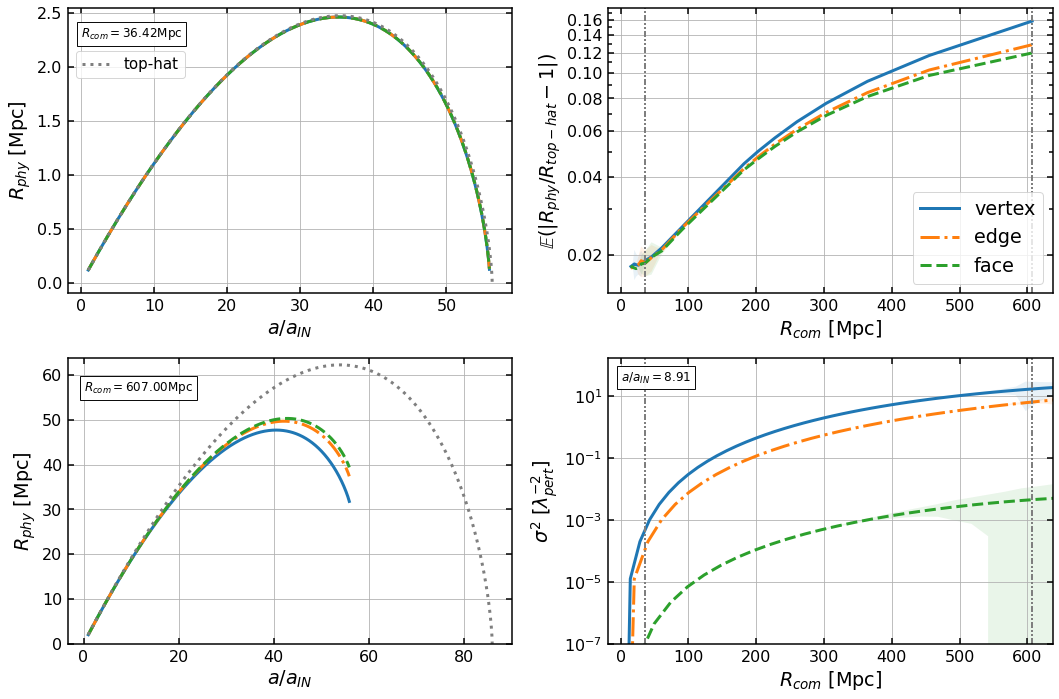

In [75]:
plt.figure(figsize=(15, 10))

alphafac = 0.9
L = sim128['Lx']
t = np.array(f128['t'])
an = Lin128.an_initial(t)
H = Lin128.evo.Hprop(t)
#-----------------------------------------------------------------------------
# Plot R(t) for small radius
plt.subplot(221)
i = 50
L = 1
#------- vertice
Rv = np.array(f128['r_vertice_prop_'+str(i)])/L
plt.plot(an, Rv)
err = get_error(np.array(f32['r_vertice_prop_'+str(i)])/L, 
                np.array(f64['r_vertice_prop_'+str(i)])/L, Rv)
plt.fill_between(an, Rv-err, Rv+err, alpha=alphafac)
#------- edge
Re = np.array(f128['r_edge_prop_'+str(i)])/L
plt.plot(an, Re, linestyle='-.')
err = get_error(np.array(f32['r_edge_prop_'+str(i)])/L, 
                np.array(f64['r_edge_prop_'+str(i)])/L, Re)
plt.fill_between(an, Re-err, Re+err, alpha=alphafac)
#------- face
Rf = np.array(f128['r_face_prop_'+str(i)])/L
plt.plot(an, Rf, linestyle='--')
err = get_error(np.array(f32['r_face_prop_'+str(i)])/L, 
                np.array(f64['r_face_prop_'+str(i)])/L, Rf)
plt.fill_between(an, Rf-err, Rf+err, alpha=alphafac)
#------- SCM
anR, R, M = getRt(Lin128, sim128, f128, i)
plt.plot(anR, R/L, color='C7', linestyle=':', label='top-hat')
#------- Hubble horizon
#plt.plot(an, 1/(L*H), 'C7--', label=r'$c/H$')
#------- Schwarzschild radius
#Rsval = 2*nf128['Mass_prop_'+str(i)][0]/L
#Rs = np.array([Rsval]*len(an))
#plt.axhline(y=Rsval, color='C7', linestyle='-.', label=r'$2GM/c^2$')
#err = get_error(np.array([2*nf32['Mass_prop_'+str(i)][0]/L]*len(an)), 
#                np.array([2*nf64['Mass_prop_'+str(i)][0]/L]*len(an)), Rs)
#plt.fill_between(an, Rs-err, Rs+err, alpha=alphafac)
#------- Format
plt.ylabel(r'$R_{phy}$'+' [Mpc]')
text = r'$R_{com}=$'+'{:.2f}'.format(36.42)+'Mpc'
plt.text(0.01, 1.25e-3*1821, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.xlabel(r'$a/a_{IN}$')
plt.grid()
plt.legend(fontsize=15, bbox_to_anchor=(0.28, 0.875))
plt.ylim(-5e-5*1821, 0.0014*1821)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
#-----------------------------------------------------------------------------
# Plot R(t) for large radius
ax = plt.subplot(223)
i = 3
#------- vertice
Rv = np.array(f128['r_vertice_prop_'+str(i)])/L
plt.plot(an, Rv)
err = get_error(np.array(f32['r_vertice_prop_'+str(i)])/L, 
                np.array(f64['r_vertice_prop_'+str(i)])/L, Rv)
plt.fill_between(an, Rv-err, Rv+err, alpha=alphafac)
#------- edge
Re = np.array(f128['r_edge_prop_'+str(i)])/L
plt.plot(an, Re, linestyle='-.')
err = get_error(np.array(f32['r_edge_prop_'+str(i)])/L, 
                np.array(f64['r_edge_prop_'+str(i)])/L, Re)
plt.fill_between(an, Re-err, Re+err, alpha=alphafac)
#------- face
Rf = np.array(f128['r_face_prop_'+str(i)])/L
plt.plot(an, Rf, linestyle='--')
err = get_error(np.array(f32['r_face_prop_'+str(i)])/L, 
                np.array(f64['r_face_prop_'+str(i)])/L, Rf)
plt.fill_between(an, Rf-err, Rf+err, alpha=alphafac)
#------- SCM
anR, R, M = getRt(Lin128, sim128, f128, i)
plt.plot(anR, R/L, color='C7', linestyle=':', label='SCM')
#------- Hubble horizon
#plt.plot(an, 1/(L*H), 'C7--')
#------- Schwarzschild radius
#Rsval = 2*nf128['Mass_prop_'+str(i)][0]/L
#Rs = np.array([Rsval]*len(anR))
#plt.axhline(y=Rsval, color='C7', linestyle='-.')
#err = get_error(np.array([2*nf32['Mass_prop_'+str(i)][0]/L]*len(anR)), 
#                np.array([2*nf64['Mass_prop_'+str(i)][0]/L]*len(anR)), Rs)
#plt.fill_between(anR, Rs-err, Rs+err, color='C7', alpha=alphafac)
#------- Format
plt.ylabel(r'$R_{phy}$'+' [Mpc]')
text = r'$R_{com}=$'+'{:.2f}'.format(607.0)+'Mpc'
plt.text(0.01, 3.1e-2*1821, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.xlabel(r'$a/a_{IN}$')
#plt.legend()
plt.grid()
plt.ylim(0, 0.035*1821)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

#-----------------------------------------------------------------------------
# Zoom Plot R(t) for large radius
#axins = ax.inset_axes([0.28, 0.14, 0.3, 0.3])
#alphafac = 0.1
#------- vertice
#Rv = np.array(f128['r_vertice_prop_'+str(i)])/L
#axins.plot(an, Rv)
#err = get_error(np.array(f32['r_vertice_prop_'+str(i)])/L, 
#                np.array(f64['r_vertice_prop_'+str(i)])/L, Rv)
#axins.fill_between(an, Rv-err, Rv+err, alpha=alphafac)
#------- edge
#Re = np.array(f128['r_edge_prop_'+str(i)])/L
#axins.plot(an, Re, linestyle='-.')
#err = get_error(np.array(f32['r_edge_prop_'+str(i)])/L, 
#                np.array(f64['r_edge_prop_'+str(i)])/L, Re)
#axins.fill_between(an, Re-err, Re+err, alpha=alphafac)
#------- face
#Rf = np.array(f128['r_face_prop_'+str(i)])/L
#axins.plot(an, Rf, linestyle='--')
#err = get_error(np.array(f32['r_face_prop_'+str(i)])/L, 
#                np.array(f64['r_face_prop_'+str(i)])/L, Rf)
#axins.fill_between(an, Rf-err, Rf+err, alpha=alphafac)
#------- SCM
#anR, R, M = getRt(Lin128, sim128, f128, i)
#axins.plot(anR, R/L, color='C7', linestyle=':', label='SCM')
#------- Hubble horizon
#axins.plot(an, 1/(L*H), 'C7--')
#------- Schwarzschild radius
#Rsval = 2*nf128['Mass_prop_'+str(i)][0]/L
#Rs = np.array([Rsval]*len(anR))
#axins.axhline(y=Rsval, color='C7', linestyle='-.')
#err = get_error(np.array([2*nf32['Mass_prop_'+str(i)][0]/L]*len(anR)), 
#                np.array([2*nf64['Mass_prop_'+str(i)][0]/L]*len(anR)), Rs)
#axins.fill_between(anR, Rs-err, Rs+err, color='C7', alpha=alphafac)
#------- Format
#axins.grid()
#axins.set_ylim(1.975e-3*1821, 2.1e-3*1821)
#axins.set_xlim(1.79, 1.88)
#axins.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#axins.tick_params(axis='both', which='major', labelsize=10)
#axins.tick_params(axis='both', which='minor', labelsize=10)
#axins.yaxis.offsetText.set_fontsize(10)

#-----------------------------------------------------------------------------
# Relative difference
ax = plt.subplot(222)
alphafac = 0.1
L = 1821
#------- vertice
plt.semilogy(L/reldiff128[0], reldiff128[1], linestyle='-', label='vertex')
err = get_error(reldiff32[1], reldiff64[1], reldiff128[1])
plt.fill_between(L/reldiff128[0], reldiff128[1]-err, reldiff128[1]+err, alpha=alphafac)
#------- edge
plt.semilogy(L/reldiff128[0], reldiff128[2], linestyle='-.', label='edge')
err = get_error(reldiff32[2], reldiff64[2], reldiff128[2])
plt.fill_between(L/reldiff128[0], reldiff128[2]-err, reldiff128[2]+err, alpha=alphafac)
#------- face
plt.semilogy(L/reldiff128[0], reldiff128[3], linestyle='--', label='face')
err = get_error(reldiff32[3], reldiff64[3], reldiff128[3])
plt.fill_between(L/reldiff128[0], reldiff128[3]-err, reldiff128[3]+err, alpha=alphafac)
#------- R_com 
plt.axvline(x=L/3, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
plt.axvline(x=L/50, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
#------- Format
plt.grid()#b=True, which='major')
#plt.grid(b=True, which='minor')
plt.legend(loc=4)
plt.xlabel(r'$R_{com}$'+' [Mpc]')
plt.ylabel(r'$\mathbb{E}(|R_{phy}/R_{top-hat}-1|)$')
plt.xlim(-0.01*L, 0.35*L)
ticklab = ['', '0.02', '0.04', '0.06', '0.08', 
           '0.10', '0.12', '0.14', '0.16']
#ax.set_yticks(tickloc)
ax.yaxis.set_minor_locator(tck.MultipleLocator(0.01))
ax.yaxis.set_major_locator(tck.MultipleLocator(0.02))
ax.set_yticklabels(ticklab)
ax.yaxis.set_minor_formatter(tck.NullFormatter())

#-----------------------------------------------------------------------------
# Shear
plt.subplot(224)
L2 = L*L
#------- vertice, edge, face
ls = ['-', '-.', '--']
lab = ['vertex', 'edge', 'face']
for i in range(3):
    plt.semilogy(r[i], var[i]*L2, linestyle=ls[i], label=lab[i])
    err = get_error(var32[i]*L2, var64[i]*L2, var[i]*L2)
    plt.fill_between(r[i], var[i]*L2-err, var[i]*L2+err, alpha=alphafac)
#------- R_com 
plt.axvline(x=L/3, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
plt.axvline(x=L/50, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
#------- Format
plt.grid()
plt.ylabel(r'$\sigma^2$'+' ['+r'$\lambda_{pert}^{-2}$'+']')
plt.xlabel(r'$R_{com}$'+' [Mpc]')
text = r'$a/a_{IN}=$'+'{:.2f}'.format(Lin128.temp_from_temp('an', 'it', it))
plt.text(0, 30, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.ylim(1e-7, 165)
plt.xlim(-0.01*L, 0.35*L)

#-----------------------------------------------------------------------------
# Format
plt.subplots_adjust(wspace = 0.2, hspace=0.2)
plt.tight_layout()
plt.savefig(sim128['HorSpath']+sim128['simname']+'/plots/R(t)_shear.pdf')

ValueError: too many values to unpack (expected 2)

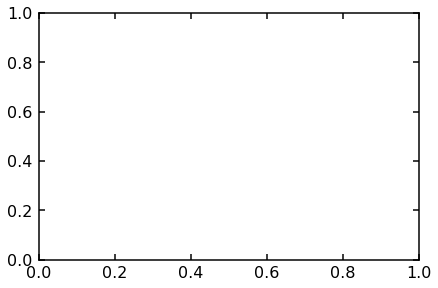

In [18]:
plt.figure(figsize=(15, 10))

alphafac = 0.9

plt.subplot(221)
i = 50
anR, R = getRt(Lin128, sim128, f128, i)
an = Lin128.an_initial(np.array(f128['t']))
plt.plot(an, f128['r_vertice_prop_'+str(i)]/sim128['Lx'])#, label='vertice')
plt.plot(an, f128['r_edge_prop_'+str(i)]/sim128['Lx'], linestyle='-.')#, label='edge')
plt.plot(an, f128['r_face_prop_'+str(i)]/sim128['Lx'], linestyle='--')#, label='face')
err = get_error(np.array(f32['r_vertice_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_vertice_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_vertice_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(an, f128['r_vertice_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_vertice_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
err = get_error(np.array(f32['r_edge_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_edge_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_edge_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(an, f128['r_edge_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_edge_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
err = get_error(np.array(f32['r_face_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_face_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_face_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(an, f128['r_face_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_face_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)

plt.plot(anR, R/sim128['Lx'], color='C7', linestyle=':', label='SCM')
plt.plot(an, 1/(sim128['Lx']*Lin128.evo.Hprop(np.array(f128['t']))), 'C7--', label=r'$c/H$')
Sradius = 2*np.array(f128['Mass_prop_'+str(i)])[0]/sim128['Lx']
plt.axhline(y=Sradius, color='C7', linestyle='-.', label=r'$2GM/c^2$')

plt.ylabel(r'$R_{phy}$'+' ['+r'$\lambda_{pert}$'+']')
text = r'$R_{com}=$'+'{:.2f}'.format(1/i)+r'$\lambda_{pert}$'
plt.text(0.01, 1.25e-3, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.xlabel(r'$a/a_{IN}$')
plt.grid()
plt.legend(loc='center', ncol=3, fontsize=15, bbox_to_anchor=(0.56, 1.075))
plt.ylim(-5e-5, 0.0014)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
plt.subplot(223)
i = 3
anR, R = getRt(Lin128, sim128, f128, i)
plt.plot(Lin128.an_initial(np.array(f128['t'])), f128['r_vertice_prop_'+str(i)]/sim128['Lx'])#, label='vertice')
plt.plot(Lin128.an_initial(np.array(f128['t'])), f128['r_edge_prop_'+str(i)]/sim128['Lx'], linestyle='-.')#, label='edge')
plt.plot(Lin128.an_initial(np.array(f128['t'])), f128['r_face_prop_'+str(i)]/sim128['Lx'], linestyle='--')#, label='face')
err = get_error(np.array(f32['r_vertice_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_vertice_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_vertice_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(Lin128.an_initial(np.array(f128['t'])), 
                 f128['r_vertice_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_vertice_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
err = get_error(np.array(f32['r_edge_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_edge_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_edge_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(Lin128.an_initial(np.array(f128['t'])), 
                 f128['r_edge_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_edge_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
err = get_error(np.array(f32['r_face_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_face_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_face_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(Lin128.an_initial(np.array(f128['t'])), 
                 f128['r_face_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_face_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
plt.plot(anR, R/sim128['Lx'], color='C7', linestyle=':', label='SCM')
plt.plot(Lin128.an_initial(np.array(f128['t'])), 
         1/(sim128['Lx']*Lin128.evo.Hprop(np.array(f128['t']))), 'C7--', label=r'$c/H$')
Sradius = 2*np.array(f128['Mass_prop_'+str(i)])[0]/sim128['Lx']
plt.axhline(y=Sradius, color='C7', linestyle='-.', label=r'$2GM/c^2$')
plt.ylabel(r'$R_{phy}$'+' ['+r'$\lambda_{pert}$'+']')
text = r'$R_{com}=$'+'{:.2f}'.format(1/i)+r'$\lambda_{pert}$'
plt.text(0.01, 3.1e-2, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.xlabel(r'$a/a_{IN}$')
#plt.legend()
plt.grid()
plt.ylim(0, 0.035)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax = plt.subplot(222)
# Relative difference
alphafac = 0.1
plt.plot(1/reldiff128[0], reldiff128[1], linestyle='-', label='vertice')
err = get_error(reldiff32[1], reldiff64[1], reldiff128[1])
plt.fill_between(1/reldiff128[0], reldiff128[1]-err, reldiff128[1]+err, alpha=alphafac)
plt.plot(1/reldiff128[0], reldiff128[2], linestyle='-.', label='edge')
err = get_error(reldiff32[2], reldiff64[2], reldiff128[2])
plt.fill_between(1/reldiff128[0], reldiff128[2]-err, reldiff128[2]+err, alpha=alphafac)
plt.plot(1/reldiff128[0], reldiff128[3], linestyle='--', label='face')
err = get_error(reldiff32[3], reldiff64[3], reldiff128[3])
plt.fill_between(1/reldiff128[0], reldiff128[3]-err, reldiff128[3]+err, alpha=alphafac)
plt.axvline(x=1/3, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
plt.axvline(x=1/50, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
plt.grid()
plt.legend(loc=2)
plt.xlabel(r'$R_{com}$'+' ['+r'$\lambda_{pert}$'+']')
plt.ylabel(r'$\mathbb{E}(|R_{phy}/R_{SCM}-1|)$')
plt.xlim(-0.01, 0.35)
ax.set_yticks([0.03, 0.06, 0.09, 0.12, 0.15])

plt.subplot(224)
# Shear
it = 0
L2 = sim128['Lx']*sim128['Lx']
plt.plot(r[0]/sim128['Lx'], var[0]*L2, linestyle='-', label='vertice')
err = get_error(var32[0]*L2, var64[0]*L2, var[0]*L2)
plt.fill_between(r[0]/sim128['Lx'], var[0]*L2-err, var[0]*L2+err, alpha=alphafac)
plt.plot(r[1]/sim128['Lx'], var[1]*L2, linestyle='-.', label='edge')
err = get_error(var32[1]*L2, var64[1]*L2, var[1]*L2)
plt.fill_between(r[1]/sim128['Lx'], var[1]*L2-err, var[1]*L2+err, alpha=alphafac)
plt.plot(r[2]/sim128['Lx'], var[2]*L2, linestyle='--', label='face')
err = get_error(var16[2]*L2, var32[2]*L2, var[2]*L2)
plt.fill_between(r[2]/sim128['Lx'], var[2]*L2-err, var[2]*L2+err, alpha=alphafac)
plt.axvline(x=1/3, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
plt.axvline(x=1/50, color='C7', linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=2)
plt.grid()
#plt.legend(loc=2)
plt.ylabel(r'$\sigma^2$'+' ['+r'$\lambda_{pert}$'+']')
plt.xlabel(r'$R_{com}$'+' ['+r'$\lambda_{pert}$'+']')
text = r'$a/a_{IN}=$'+'{:.2f}'.format(Lin128.temp_from_temp('an', 'it', it))
plt.text(0, 147, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.ylim(-10, 165)
plt.xlim(-0.01, 0.35)
plt.subplots_adjust(wspace = 0.2, hspace=0.2)

(1.79, 1.88)

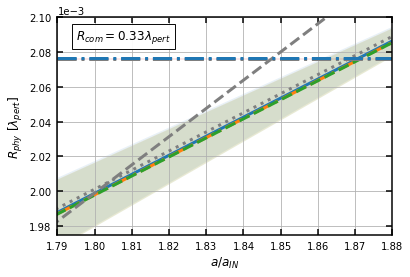

In [20]:
i = 3
anR, R = getRt(Lin128, sim128, f128, i)
plt.plot(Lin128.an_initial(np.array(f128['t'])), f128['r_vertice_prop_'+str(i)]/sim128['Lx'])#, label='vertice')
plt.plot(Lin128.an_initial(np.array(f128['t'])), f128['r_edge_prop_'+str(i)]/sim128['Lx'], linestyle='-.')#, label='edge')
plt.plot(Lin128.an_initial(np.array(f128['t'])), f128['r_face_prop_'+str(i)]/sim128['Lx'], linestyle='--')#, label='face')
err = get_error(np.array(f32['r_vertice_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_vertice_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_vertice_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(Lin128.an_initial(np.array(f128['t'])), 
                 f128['r_vertice_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_vertice_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
err = get_error(np.array(f32['r_edge_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_edge_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_edge_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(Lin128.an_initial(np.array(f128['t'])), 
                 f128['r_edge_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_edge_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
err = get_error(np.array(f32['r_face_prop_'+str(i)])/sim128['Lx'], 
                np.array(f64['r_face_prop_'+str(i)])/sim128['Lx'], 
                np.array(f128['r_face_prop_'+str(i)])/sim128['Lx'])
plt.fill_between(Lin128.an_initial(np.array(f128['t'])), 
                 f128['r_face_prop_'+str(i)]/sim128['Lx']-err, 
                 f128['r_face_prop_'+str(i)]/sim128['Lx']+err, alpha=alphafac)
plt.plot(anR, R/sim128['Lx'], color='C7', linestyle=':', label='SCM')
plt.plot(Lin128.an_initial(np.array(f128['t'])), 
         1/(sim128['Lx']*Lin128.evo.Hprop(np.array(f128['t']))), 'C7--', label=r'$c/H$')
Sradius = 2*np.array(f128['Mass_prop_'+str(i)])[0]/sim128['Lx']
Sradius32 = 2*np.array(f32['Mass_prop_'+str(i)])[0]/sim128['Lx']
Sradius64 = 2*np.array(f64['Mass_prop_'+str(i)])[0]/sim128['Lx']
plt.axhline(y=Sradius, color='C7', linestyle='-.', label=r'$2GM/c^2$')
err = get_error(np.array([Sradius32]*len(R)), 
                np.array([Sradius64]*len(R)), 
                np.array([Sradius]*len(R)))
plt.fill_between(an, np.array([Sradius]*len(R))-err, np.array([Sradius]*len(R))+err, alpha=alphafac)
#-------
Sradius = 2*np.array(nf128['Mass_prop_'+str(i)])[0]/sim128['Lx']
plt.axhline(y=Sradius, color='C0', linestyle='-.', label=r'$2GM/c^2$')
Sradius32 = 2*np.array(nf32['Mass_prop_'+str(i)])[0]/sim128['Lx']
Sradius64 = 2*np.array(nf64['Mass_prop_'+str(i)])[0]/sim128['Lx']
err = get_error(np.array([Sradius32]*len(R)), 
                np.array([Sradius64]*len(R)), 
                np.array([Sradius]*len(R)))
plt.fill_between(an, np.array([Sradius]*len(R))-err, np.array([Sradius]*len(R))+err, alpha=alphafac)
#-------
plt.ylabel(r'$R_{phy}$'+' ['+r'$\lambda_{pert}$'+']')
text = r'$R_{com}=$'+'{:.2f}'.format(1/i)+r'$\lambda_{pert}$'
plt.text(1.795, 2.0875e-3, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.xlabel(r'$a/a_{IN}$')
#plt.legend()
plt.grid()
plt.ylim(0, 0.035)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ylim(1.975e-3, 2.1e-3)
plt.xlim(1.79, 1.88)

0.002075781118091013
0.002075781118091013


(0.002075775, 0.002075783)

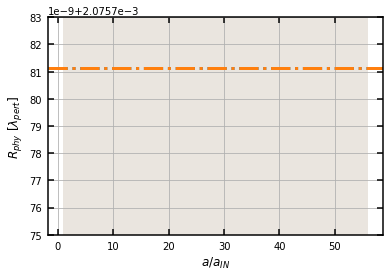

In [18]:
i = 3

#-------
Sradius = 2*np.array(nf128['Mass_prop_'+str(i)])[0]/(sim128['Lx'])
print(Sradius)
plt.axhline(y=Sradius, color='C0', linestyle='-.')
Sradius32 = 2*np.array(nf32['Mass_prop_'+str(i)])[0]/(sim128['Lx'])
Sradius64 = 2*np.array(nf64['Mass_prop_'+str(i)])[0]/(sim128['Lx'])
err = get_error(np.array([Sradius32]*len(R)), 
                np.array([Sradius64]*len(R)), 
                np.array([Sradius]*len(R)))
plt.fill_between(an, np.array([Sradius]*len(R))-err, np.array([Sradius]*len(R))+err, alpha=alphafac)
#-------
Sradius = 2*np.array(f128['Mass_prop_'+str(i)])[0]/sim128['Lx']
print(Sradius)
Sradius32 = 2*np.array(f32['Mass_prop_'+str(i)])[0]/sim128['Lx']
Sradius64 = 2*np.array(f64['Mass_prop_'+str(i)])[0]/sim128['Lx']
plt.axhline(y=Sradius, color='C1', linestyle='-.')
err = get_error(np.array([Sradius32]*len(R)), 
                np.array([Sradius64]*len(R)), 
                np.array([Sradius]*len(R)))
plt.fill_between(an, np.array([Sradius]*len(R))-err, np.array([Sradius]*len(R))+err, alpha=alphafac)
plt.ylabel(r'$R_{phy}$'+' ['+r'$\lambda_{pert}$'+']')
text = r'$R_{com}=$'+'{:.2f}'.format(1/i)+r'$\lambda_{pert}$'
#plt.text(1.795, 2.0875e-3, text, fontsize=12, bbox=dict(facecolor='white', alpha=0.95))
plt.xlabel(r'$a/a_{IN}$')
#plt.legend()
plt.grid()
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ylim(2.075775e-3, 2.075783e-3)
#plt.xlim(1.79, 1.88)